In [28]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.metrics import v_measure_score

Загружаем датасет об оппосумах

In [45]:
data = pd.read_csv("/content/possum.csv")
data.head(3)

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0


Смотрим пропуски и стат информацию

In [46]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


,case,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,52.500000,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,30.166206,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,26.750000,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,52.500000,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,78.250000,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,104.000000,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


Удалим пропущенные значения

In [47]:
data = data.dropna()

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      101 non-null    int64  
 1   site      101 non-null    int64  
 2   Pop       101 non-null    object 
 3   sex       101 non-null    object 
 4   age       101 non-null    float64
 5   hdlngth   101 non-null    float64
 6   skullw    101 non-null    float64
 7   totlngth  101 non-null    float64
 8   taill     101 non-null    float64
 9   footlgth  101 non-null    float64
 10  earconch  101 non-null    float64
 11  eye       101 non-null    float64
 12  chest     101 non-null    float64
 13  belly     101 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.8+ KB


Таргетом в данной задаче будет пол - женский и мужской.
Закодируем столбец и удалим его из исходного датасета

In [49]:
data['sex'] = data['sex'].apply(lambda x: 0 if x == "m" else 1)
y = data.pop('sex')

Посмотрим, есть ли дисбаланс классов

In [50]:
y.value_counts()

,count
sex,
0,59
1,42


Классы сбалансированы

Кодируем категориальные столбцы

In [51]:
categorical_columns = [
    c for c in data.columns if data[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data.columns if data[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Pop']
numerical_columns: ['case', 'site', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']


In [52]:
df = pd.concat(
    [data[numerical_columns], pd.get_dummies(data[categorical_columns])],
    axis=1,
)

Масштабируем

In [53]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

Метод главных компонент

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_new = pca.fit_transform(df_scaled)

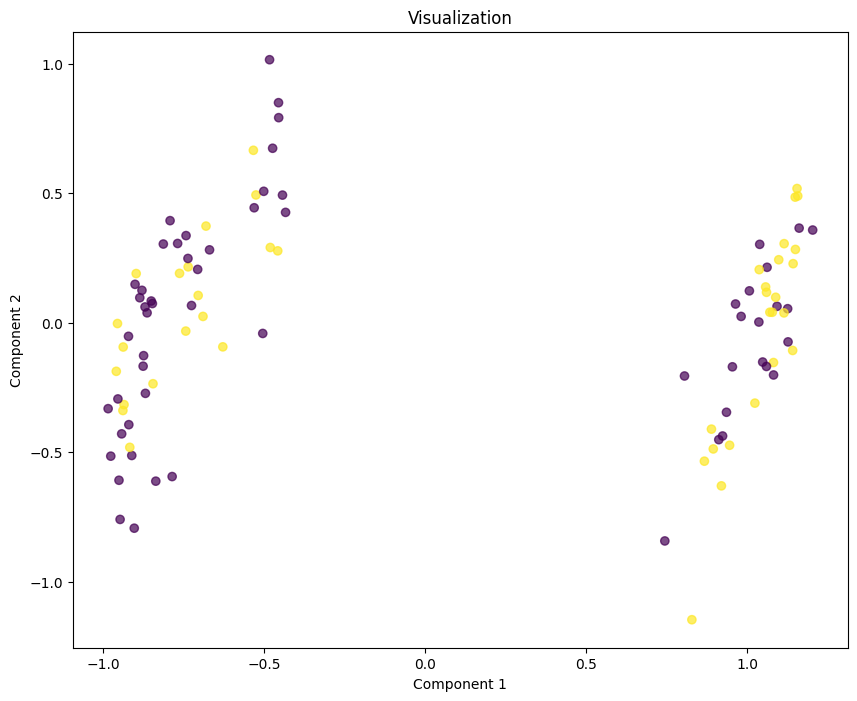

In [55]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_new[:, 0], X_new[:, 1], c=y, cmap='viridis', marker='o', alpha=0.7)
plt.title('Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [56]:
pca.explained_variance_ratio_

array([0.69517414, 0.12978776])

Как вы можете видеть выше, первые главные компоненты сохраняют 69% дисперсии набора данных, тогда как вторые главные компоненты сохраняют только 12% дисперсии.

Независимый анализ компонентов

In [57]:
from sklearn.decomposition import FastICA

fast_ica = FastICA(n_components=2)
X_isa = fast_ica.fit_transform(df_scaled)

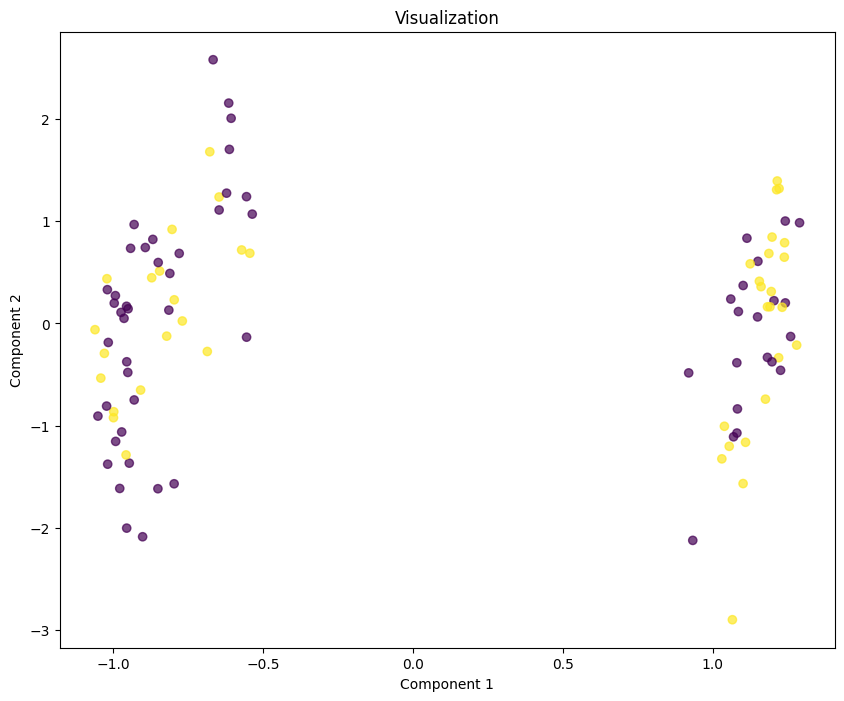

In [58]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_isa[:, 0], X_isa[:, 1], c=y, cmap='viridis', marker='o', alpha=0.7)
plt.title('Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Kernel PCA

In [59]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_kernelpca = rbf_pca.fit_transform(df_scaled)

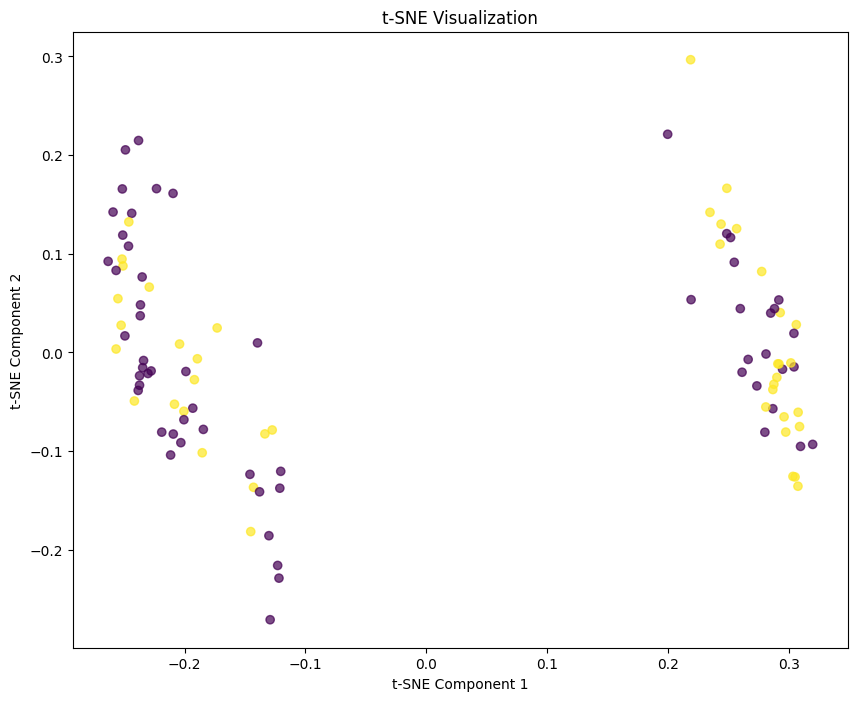

In [60]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_kernelpca[:, 0], X_kernelpca[:, 1], c=y, cmap='viridis', marker='o', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

t-SNE

In [61]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
df_tsne = tsne.fit_transform(df_scaled)

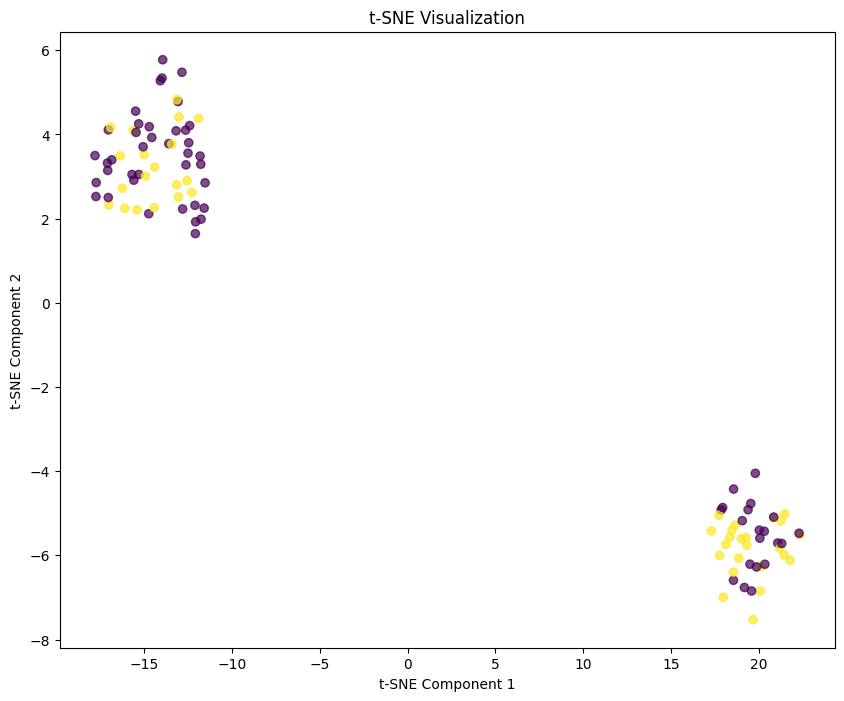

In [62]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=y, cmap='viridis', marker='o', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

DBSCAN для кластеризации

In [63]:
dbsc = DBSCAN(eps=0.28, min_samples=3)
labels_dbsc = dbsc.fit_predict(df_scaled)

In [64]:
# Number of Clusters
labels=dbsc.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbsc.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 0
Estimated no. of noise points: 101
v_measure = 0.0


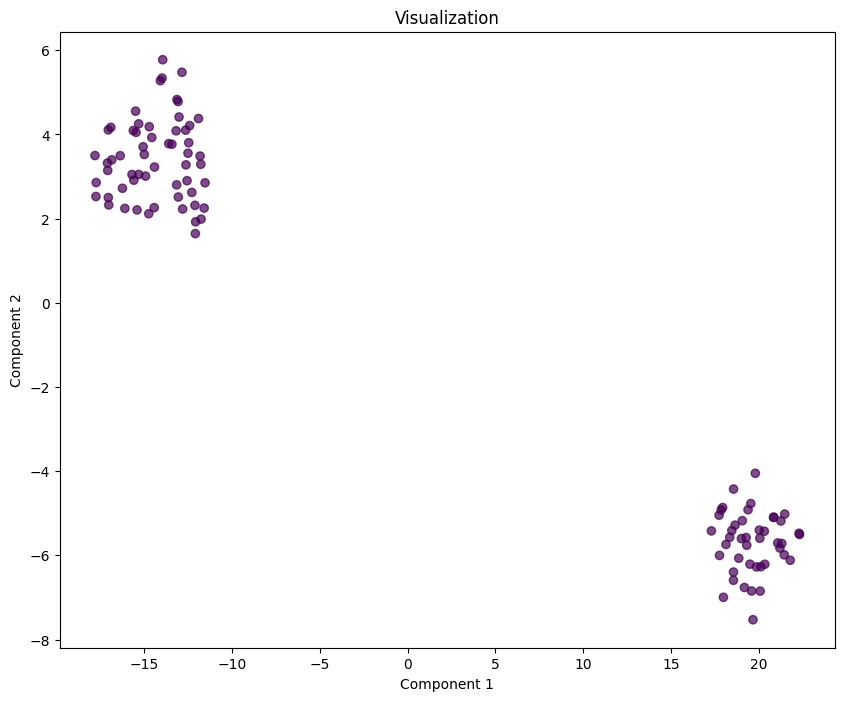

In [65]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=labels_dbsc, marker='o', alpha=0.7)
plt.title('Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Чтобы правильно опрделить число eps, воспользуемся правилом локтя.

In [66]:
from sklearn.neighbors import NearestNeighbors

min_samples = 5

knn = NearestNeighbors(n_neighbors = min_samples, metric = 'l2')
knn.fit(df_scaled)

dists, inds = knn.kneighbors(df_scaled)
dists_ar = dists[:, 1:min_samples].mean(axis=1)
dists_ar.sort()

In [67]:
import sklearn
#возможные метрики расстояния
sklearn.metrics.pairwise.distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

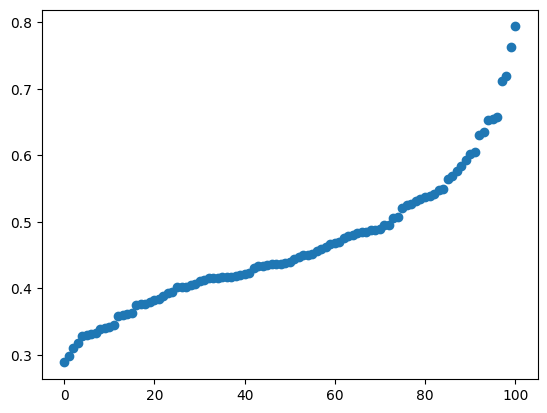

In [68]:
plt.scatter(x = range(len(dists_ar)), y=dists_ar)
plt.show()

In [82]:
dbsc = DBSCAN(eps=0.5, min_samples=5)
labels_dbsc = dbsc.fit_predict(df_scaled)

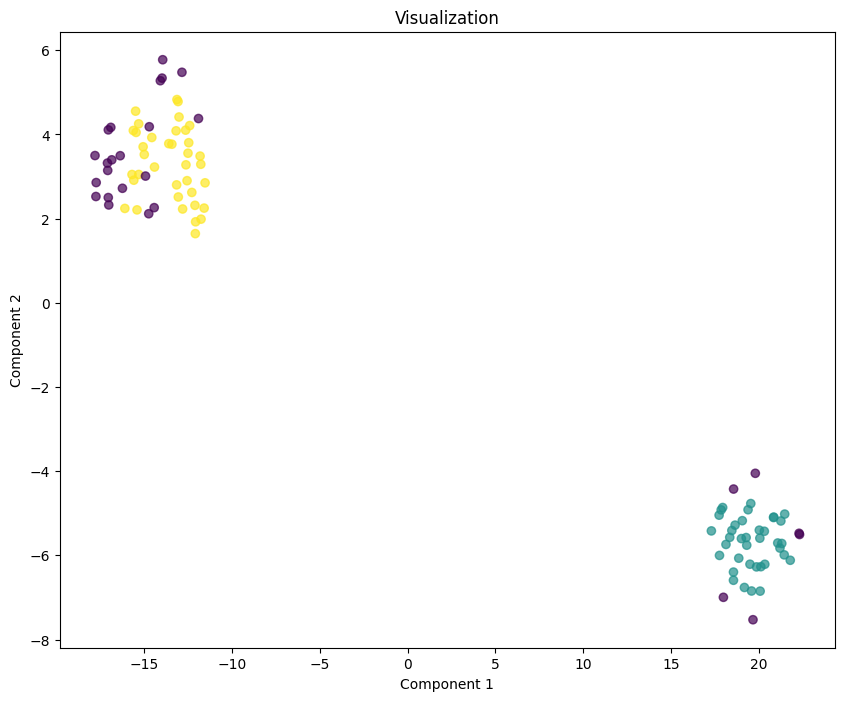

In [83]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=labels_dbsc, marker='o', alpha=0.7)
plt.title('Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

DBSCAN для определения выбросов

In [84]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)
print(dbscan)

DBSCAN()


In [85]:
pred = dbscan.fit_predict(df_scaled)

In [86]:
# Number of Clusters
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 2
Estimated no. of noise points: 27
v_measure = 0.02168428082397328


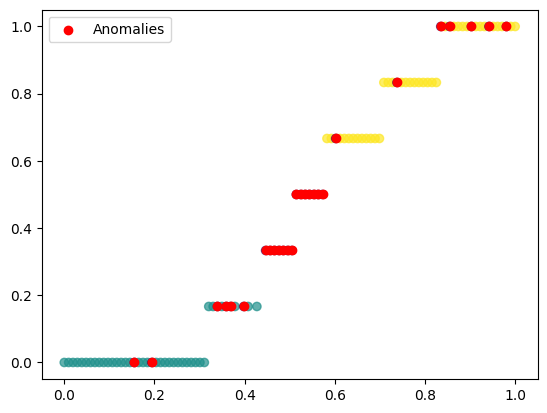

In [93]:
anom_index = [i for i in range(len(labels)) if labels[i] == -1]

df_scaled = pd.DataFrame(df_scaled)

values = df_scaled.iloc[anom_index]

cols = df_scaled.columns[:2]

plt.scatter(df_scaled[cols[0]], df_scaled[cols[1]], c=labels, cmap='viridis', marker='o', alpha=0.7)
plt.scatter(values[cols[0]], values[cols[1]], color='r', label='Anomalies')
plt.legend()
plt.show()